## Extracting patterns on leads 

We are going to play with the following dataset

1.- **Dataset name to request access:** Insights-FactLayer-Leads

2.- **Athena (SQLaaS):** {provider}_databox.insights_leads_fact_layer_90d.

3.- **S3 path** s3://schibsted-spt-common-prod/yellow/insights/leads/

[More information](https://docs.schibsted.io/data-and-insight/insights-pipelines/10.Data%20Model/fact-layer/#sessions-user-behaviour)

In [1]:
# Needed packages
from pyathena import connect
import pandas as pd
import os

In [2]:
from getpass import getpass
access_key = getpass(prompt="Enter your access key to databox: ")
secret_key = getpass(prompt="Enter your secret to databox: ")

# Some parameters (another different way to extract the credential)
user = "maria.pelaez@schibsted.com/"
provider ='yapocl'

# Doing the connection
conn = connect(aws_access_key_id=access_key,
               aws_secret_access_key=secret_key,
               s3_staging_dir="s3://schibsted-spt-common-dev/user-areas/"+ user,
               region_name="eu-west-1")

Enter your access key to databox: ········
Enter your secret to databox: ········


In [3]:
%%time

# Doing a simple query

query_leads = """
SELECT
  *
FROM
  {}_databox.insights_leads_fact_layer_90d
LIMIT 10
"""
df_leads = pd.read_sql(query_leads.format(provider), conn)

CPU times: user 118 ms, sys: 14.7 ms, total: 132 ms
Wall time: 3.98 s


In [4]:
df_leads.count()

leadid                 10
globalleadtype         10
environmentid          10
eventtype              10
eventobject            10
published              10
clientid               10
country                10
adid                   10
adlocalcategory        10
adlocalmaincategory    10
adtype                 10
adpublishertype        10
adlocation              0
adlocalvertical        10
devicetype             10
producttype             5
trackertype            10
source                 10
version                10
year                   10
month                  10
day                    10
gen                    10
client                 10
dtype: int64

In [5]:
df_leads.head()

,leadid,globalleadtype,environmentid,eventtype,eventobject,published,clientid,country,adid,adlocalcategory,...,devicetype,producttype,trackertype,source,version,year,month,day,gen,client
0,0004dc3c-44a1-4cc5-8b05-d1f774426005,Ad phone number called,sdrn:schibsted:environment:2ec8f2fd-2c2f-4493-...,Call,PhoneContact,2018-09-28T02:47:16+00:00,yapocl,cl,NULL,Servicios > negocios y empleo > Negocios > maq...,...,mobile,AndroidApp,JS,pulse,1,2018,9,27,0,yapocl
1,000db13d-efc0-4db2-873a-cc75ea598fcf,Ad phone number displayed,sdrn:schibsted:environment:2864bf29-7d20-4245-...,Show,PhoneContact,2018-09-28T01:11:34+00:00,yapocl,cl,NULL,Servicios > negocios y empleo > Ofertas de empleo,...,mobile,AndroidApp,JS,pulse,1,2018,9,27,0,yapocl
2,00388733-35fc-40b1-b02c-213ace354598,Ad reply submited,sdrn:schibsted:environment:a0e72ad3-9d80-4b91-...,Send,Message,2018-09-27T23:12:31+00:00,yapocl,cl,NULL,Servicios > negocios y empleo > Ofertas de em...,...,mobile,None,JS,pulse,1,2018,9,27,0,yapocl
3,0050061d-0b0f-40bc-83c8-418dc8ee9a3e,Ad reply submited,sdrn:schibsted:environment:78fa9851-adec-4c94-...,Send,Message,2018-09-27T11:44:00+00:00,yapocl,cl,NULL,Servicios > negocios y empleo > Ofertas de em...,...,mobile,None,JS,pulse,1,2018,9,27,0,yapocl
4,007a4a3a-8810-4ce2-b675-9873bfb81e23,Ad reply submited,sdrn:schibsted:environment:66352676-73e5-48f6-...,Send,Message,2018-09-28T02:18:41+00:00,yapocl,cl,NULL,Computadores & electrónica > Celulares > telé...,...,mobile,None,JS,pulse,1,2018,9,27,0,yapocl


In [6]:
%%time
# Doing a simple query
leads = """
SELECT
 globalleadtype,
 published,
 count(globalleadtype) AS nof_leads
FROM
(
 SELECT
   globalleadtype,
   substring(published,1,10) as published
 FROM
  {}_databox.insights_leads_fact_layer_90d  
)
GROUP BY 
 globalleadtype,
 published
"""
df = pd.read_sql(leads.format(provider), conn)

CPU times: user 34.2 ms, sys: 3.6 ms, total: 37.8 ms
Wall time: 3.73 s


In [7]:
df.head()

,globalleadtype,published,nof_leads
0,Ad phone number displayed,2018-08-29,81091
1,Ad reply submited,2018-09-24,159478
2,Ad phone number called,2018-09-25,131354
3,Ad SMS app opened,2018-10-07,2807
4,Ad phone number displayed,2018-10-28,117154


In [8]:
df['globalleadtype'].unique()

array(['Ad phone number displayed', 'Ad reply submited',
       'Ad phone number called', 'Ad SMS app opened'], dtype=object)

### Step 1: Prepare your data to plot

In [9]:
tabla = df.pivot_table(index='published',columns='globalleadtype',values='nof_leads')

In [10]:
tabla.head()

globalleadtype,Ad SMS app opened,Ad phone number called,Ad phone number displayed,Ad reply submited
published,,,,
2018-08-07,2481,34267,63775,109032
2018-08-08,3038,41290,78881,138496
2018-08-09,3231,39264,78406,126381
2018-08-10,742,7217,16461,29508
2018-08-11,2025,26273,48359,57631


### Step 2: Create plot

/Users/CotePelaez/anaconda/lib/python3.5/site-packages/pandas/core/indexes/base.py:2070: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


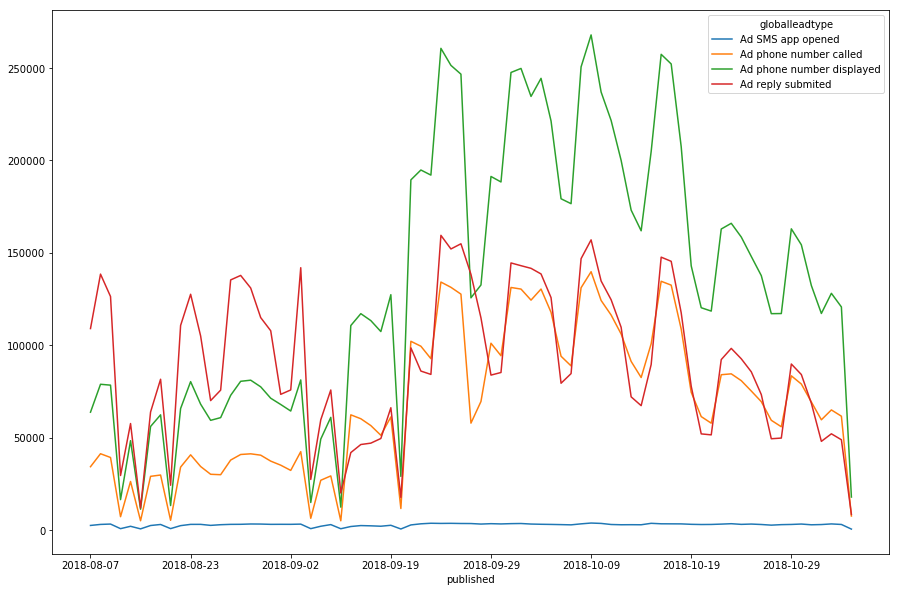

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(15,10))
tabla.plot(ax=ax)

### Step 3: Customize the plot

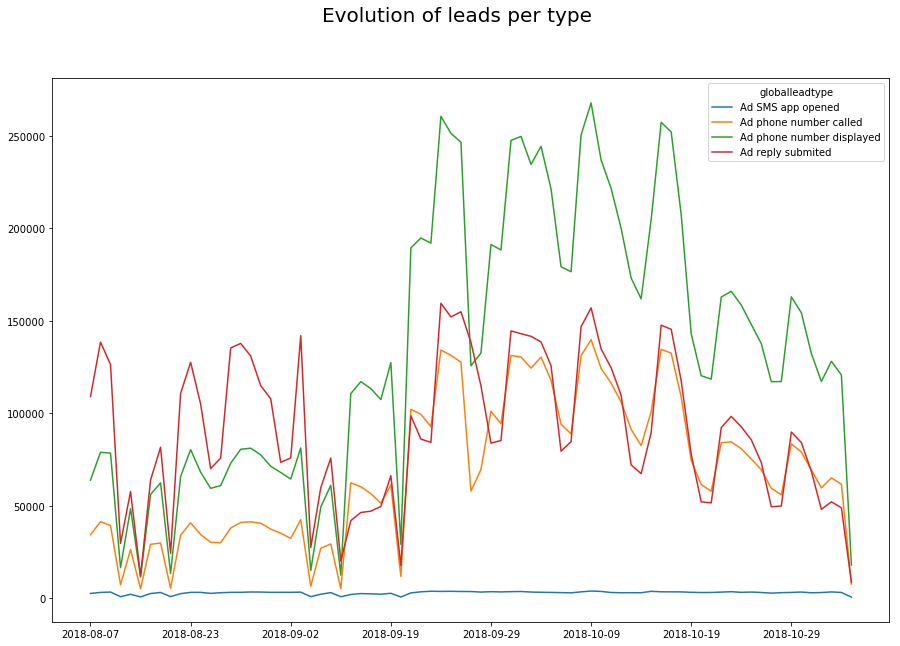

In [12]:
## Improving the labels and adding title
ax.set_xlabel("")
fig.suptitle('Evolution of leads per type',fontsize=20)
fig

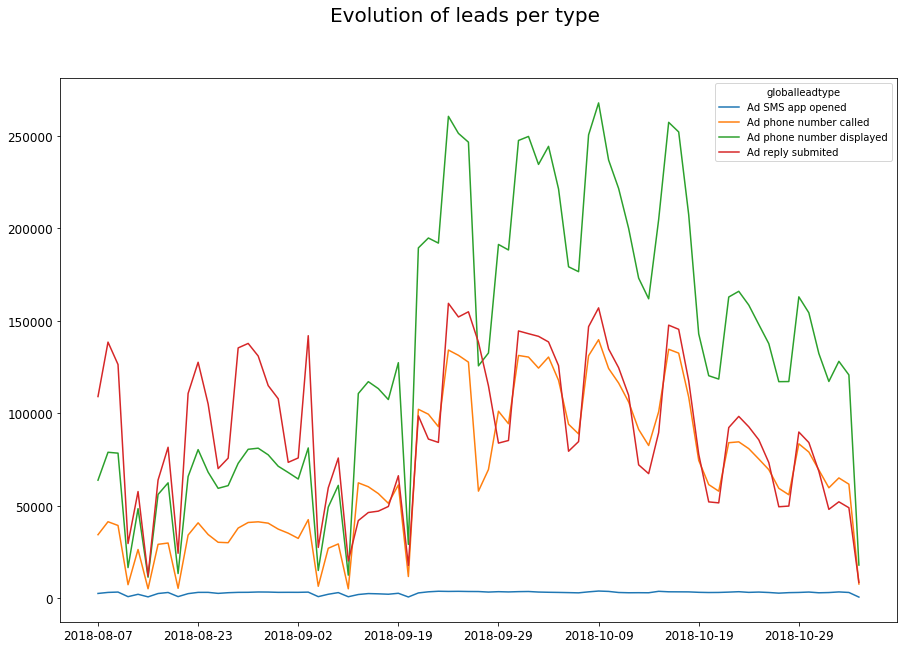

In [13]:
## fixing size of ticks
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
fig

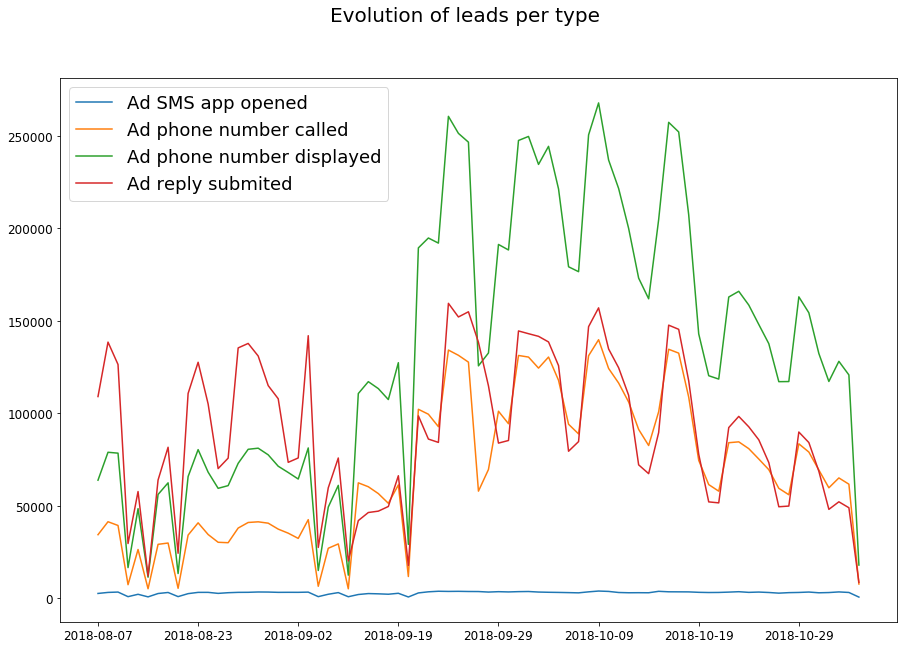

In [14]:
# Modifying the legend
ax.legend(loc='upper left',prop={'size':18})
fig

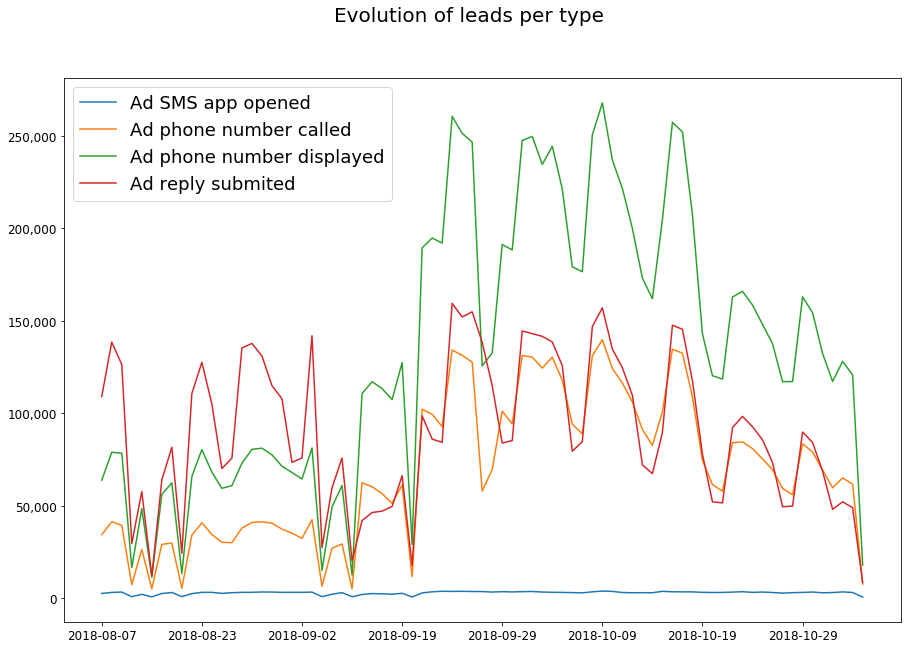

In [15]:
# Format y axis numbers
vals = ax.get_yticks()
ax.set_yticklabels(['{:,}'.format(int(x)) for x in vals])
fig

In [20]:
## A barplot
import datetime as dt

In [21]:
df['weekdate'] = pd.to_datetime(df['published']).dt.week

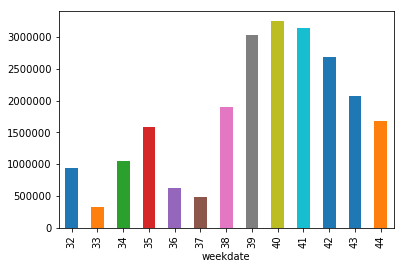

In [31]:
ax = df.groupby(['weekdate'])['nof_leads'].sum().plot(kind='bar')

## **Exercise 1**:

Customize the previous graph

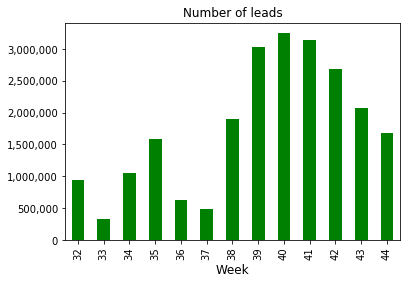

In [43]:
ax = df.groupby(['weekdate'])['nof_leads'].sum().plot(kind='bar', color='green')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_xlabel("Week", fontsize="large")
ax.set_title('Number of leads')

## **Exercise 2**:

Create a chart to visualize lead type (sms, show phone etc.) by vertical

In [44]:
%%time

query = """
SELECT 
 adlocalvertical, 
 globalleadtype, 
 count(globalleadtype) as count
FROM
  {}_databox.insights_leads_fact_layer_90d
GROUP BY 
 adlocalvertical, 
 globalleadtype
"""

leads_by_vertical = pd.read_sql(query.format(provider), conn)

CPU times: user 53.2 ms, sys: 4.42 ms, total: 57.6 ms
Wall time: 5.81 s


In [45]:
leads_by_vertical

,adlocalvertical,globalleadtype,count
0,generalist,Ad phone number called,1180979
1,unknown,Ad reply submited,5069438
2,real estate,Ad phone number called,841556
3,motor,Ad phone number called,603489
4,generalist,Ad SMS app opened,59755
5,unknown,Ad phone number displayed,5048185
6,real estate,Ad phone number displayed,1708040
7,motor,Ad phone number displayed,1219884
8,other,Ad reply submited,11908
9,motor,Ad SMS app opened,40028


In [46]:
pivot_leads_by_vertical = leads_by_vertical.pivot(index="adlocalvertical", columns="globalleadtype", values="count")

In [54]:
pivot_leads_by_vertical["total"] = pivot_leads_by_vertical["Ad SMS app opened"] +\
                                   pivot_leads_by_vertical["Ad phone number called"] +\
                                   pivot_leads_by_vertical["Ad phone number displayed"] +\
                                   pivot_leads_by_vertical["Ad reply submited"]

In [48]:
pivot_leads_by_vertical.columns[:4]

Index(['Ad SMS app opened', 'Ad phone number called',
       'Ad phone number displayed', 'Ad reply submited'],
      dtype='object', name='globalleadtype')

In [55]:
for column in pivot_leads_by_vertical.columns[:4]:
    pivot_leads_by_vertical[column] = 100*pivot_leads_by_vertical[column] / pivot_leads_by_vertical["total"]

In [56]:
pivot_leads_by_vertical = pivot_leads_by_vertical.drop("total", axis=1)

In [58]:
pivot_leads_by_vertical

globalleadtype,Ad SMS app opened,Ad phone number called,Ad phone number displayed,Ad reply submited
adlocalvertical,,,,
generalist,1.309927,25.888994,49.189173,23.611905
motor,1.880459,28.351065,57.308437,12.460039
other,1.428650,11.968817,73.435064,13.167468
real estate,0.862765,27.107138,55.017225,17.012873
unknown,0.694659,20.627423,39.256324,39.421594


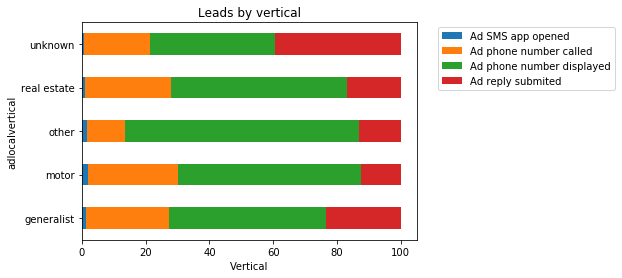

In [57]:
pivot_leads_by_vertical.plot.barh(stacked=True)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.xlabel("Vertical")
plt.title("Leads by vertical")

## **Exercise 3**:

Now we are going to create two datasets: 

* All items with the number of classified ads from {provider}_databox.yellow_pulse_simple_1d (type = "View", objecttype = "ClassifiedAd")
* All items with the number of leads
    


In [59]:
%%time

query_data1 = """
SELECT
 objectid,
 category,
 count(*) AS nof_adviews
FROM
 {}_databox.yellow_pulse_simple_1d
WHERE 
 (type='View' and objecttype = 'ClassifiedAd')
GROUP BY
 objectid,
 category
"""


query_data2 = """
SELECT
  objectid,
  count(*) as_nof_leads
FROM
 {}_databox.yellow_pulse_simple_1d
WHERE 
 (type='Call' and objecttype = 'PhoneContact') OR
 (type='Show' and objecttype = 'PhoneContact') OR
 (type='Send' and objecttype = 'Message') OR
 (type='SMS' and objecttype = 'PhoneContact')
GROUP BY
 objectid
"""
adviews = pd.read_sql(query_data1.format(provider), conn)
leads = pd.read_sql(query_data2.format(provider), conn)

CPU times: user 38.3 s, sys: 2.6 s, total: 40.9 s
Wall time: 5min 27s


Compute:
    
1) A new dataframe joining adviews and leads

2) To compute the percentage of ads with leads per category

3) How many ad views are needed to have at least one lead per category?



**Hint**: Look [this](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html)

In [60]:
!pip install unidecode

Looking in indexes: https://artifacts.schibsted.io/artifactory/api/pypi/pypi-virtual/simple


In [80]:
adviews.head()

,objectid,category,nof_adviews,id,vertical
0,sdrn:yapocl:classified:58023936,Servicios > negocios y empleo > Ofertas de empleo,12,58023936,Servicios
1,sdrn:yapocl:classified:58148917,Tiempo libre > Arte > antiguedades y colecciones,3,58148917,Tiempo libre
2,sdrn:yapocl:classified:57438424,Computadores & electronica > Celulares y telef...,1,57438424,Computadores & electronica
3,sdrn:yapocl:classified:58208491,Moda > calzado > belleza y salud > Bolsos > bi...,4,58208491,Moda
4,sdrn:yapocl:classified:58139784,Hogar > Muebles,19,58139784,Hogar


In [81]:
leads.head()

,id,as_nof_leads
0,//tags.tiqcdn.com/utag/schibsted/yapo-nga/prod...,275
1,//tags.tiqcdn.com/utag/schibsted/yapo-nga/prod...,2
2,//tags.tiqcdn.com/utag/schibsted/yapo-nga/prod...,2
3,//tags.tiqcdn.com/utag/schibsted/yapo-nga/prod...,2
4,//tags.tiqcdn.com/utag/schibsted/yapo-nga/prod...,2


In [61]:
import unidecode
#to remove accents and avoid duplicates

In [78]:
adviews["id"] = adviews["objectid"].str.split(":").apply(lambda x: x[-1])
adviews["category"] = adviews["category"].apply(lambda x: unidecode.unidecode(x)) #remove accents
adviews["category"] = adviews["category"].str.replace("  ", " ") #replace double spaces with single space
adviews["category"] = adviews["category"].str.replace("Computadore ", "Computadores ")
adviews["category"] = adviews["category"].str.replace("Futura mam ", "Futura mama ")
adviews["category"] = adviews["category"].str.replace("Otros > Otros productos", 'Otros productos')
adviews['vertical'] = adviews["category"].str.split('>').str[0]
adviews.head()

,objectid,category,nof_adviews,id,vertical
0,sdrn:yapocl:classified:58023936,Servicios > negocios y empleo > Ofertas de empleo,12,58023936,Servicios
1,sdrn:yapocl:classified:58148917,Tiempo libre > Arte > antiguedades y colecciones,3,58148917,Tiempo libre
2,sdrn:yapocl:classified:57438424,Computadores & electronica > Celulares y telef...,1,57438424,Computadores & electronica
3,sdrn:yapocl:classified:58208491,Moda > calzado > belleza y salud > Bolsos > bi...,4,58208491,Moda
4,sdrn:yapocl:classified:58139784,Hogar > Muebles,19,58139784,Hogar


In [ ]:
leads["id"] = leads["objectid"].str.split(":").apply(lambda x: x[-1])
leads.head()

In [ ]:
leads = leads.groupby("id")["as_nof_leads"].sum().reset_index()

> 1) A new dataframe joining adviews and leads

In [101]:
df_adviews_leads = pd.merge(left=adviews, right=leads, on="id", how="left").fillna(0)

In [102]:
df_adviews_leads.head(10)

,objectid,category,nof_adviews,id,vertical,as_nof_leads
0,sdrn:yapocl:classified:58023936,Servicios > negocios y empleo > Ofertas de empleo,12,58023936,Servicios,1.0
1,sdrn:yapocl:classified:58148917,Tiempo libre > Arte > antiguedades y colecciones,3,58148917,Tiempo libre,0.0
2,sdrn:yapocl:classified:57438424,Computadores & electronica > Celulares y telef...,1,57438424,Computadores & electronica,0.0
3,sdrn:yapocl:classified:58208491,Moda > calzado > belleza y salud > Bolsos > bi...,4,58208491,Moda,0.0
4,sdrn:yapocl:classified:58139784,Hogar > Muebles,19,58139784,Hogar,6.0
5,sdrn:yapocl:classified:57886773,Servicios > negocios y empleo > Negocios > maq...,3,57886773,Servicios,0.0
6,sdrn:yapocl:classified:58207277,Vehiculos > Buses > camiones y furgones,134,58207277,Vehiculos,31.0
7,sdrn:yapocl:classified:57732764,Vehiculos > Autos > camionetas y 4x4,2,57732764,Vehiculos,0.0
8,sdrn:yapocl:classified:58200018,Vehiculos > Autos > camionetas y 4x4,233,58200018,Vehiculos,10.0
9,sdrn:yapocl:classified:58175400,Hogar > Otros articulos del hogar,13,58175400,Hogar,0.0


In [103]:
df_adviews_leads["has_leads"] = df_adviews_leads["as_nof_leads"] > 0

In [107]:
df_adviews_leads_grouped = df_adviews_leads.groupby(["vertical", "has_leads"]).agg({'as_nof_leads':'sum',
                                                                                    'id':'count'})
df_adviews_leads_grouped.head(30)

as_nof_leads      id
vertical                    has_leads                      
                            False               0.0    4553
                            True             2018.0     596
Computadores & electronica  False               0.0   92703
                            True            46620.0   14813
Futura mama                 False               0.0   27242
                            True             6172.0    2290
Hogar                       False               0.0   75020
                            True            31591.0    9179
Inmuebles                   False               0.0  147882
                            True            69366.0   16123
Moda                        False               0.0   92111
                            True            17658.0    6722
Otros productos             False               0.0    4499
                            True             1430.0     489
Servicios                   False               0.0   92566
                            True           127552.0   17602
Tiempo libre                False               0.0   78503
                            True            22234.0    7874
Vehiculos                   False               0.0  400438
                            True            84662.0   29142

> 2) To compute the percentage of ads with leads per category


In [130]:
re = df_adviews_leads_grouped.groupby(level=0)\
                        .transform(lambda x: 100*x/x.sum())\
                        .reset_index()
re.head()

,vertical,has_leads,as_nof_leads,id
0,,False,0.0,88.424937
1,,True,100.0,11.575063
2,Computadores & electronica,False,0.0,86.222516
3,Computadores & electronica,True,100.0,13.777484
4,Futura mama,False,0.0,92.245700


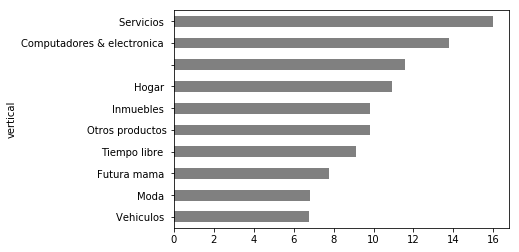

In [131]:
re[re.has_leads][['vertical','id']].sort_values('id').plot(x='vertical',
                                                           y='id',
                                                           kind='barh',
                                                           legend=False,
                                                           color='gray')

> How many ad views are needed to have at least one lead? Group by category.

In [132]:
df_adviews_leads.head()

,objectid,category,nof_adviews,id,vertical,as_nof_leads,has_leads
0,sdrn:yapocl:classified:58023936,Servicios > negocios y empleo > Ofertas de empleo,12,58023936,Servicios,1.0,True
1,sdrn:yapocl:classified:58148917,Tiempo libre > Arte > antiguedades y colecciones,3,58148917,Tiempo libre,0.0,False
2,sdrn:yapocl:classified:57438424,Computadores & electronica > Celulares y telef...,1,57438424,Computadores & electronica,0.0,False
3,sdrn:yapocl:classified:58208491,Moda > calzado > belleza y salud > Bolsos > bi...,4,58208491,Moda,0.0,False
4,sdrn:yapocl:classified:58139784,Hogar > Muebles,19,58139784,Hogar,6.0,True


In [135]:
df_adviews_leads_true = df_adviews_leads[df_adviews_leads["has_leads"] == True].copy()

In [136]:
df_adviews_leads_true["views_for_lead"] = df_adviews_leads_true["nof_adviews"] / df_adviews_leads_true["as_nof_leads"]

In [137]:
df_adviews_leads_true.head()

,objectid,category,nof_adviews,id,vertical,as_nof_leads,has_leads,views_for_lead
0,sdrn:yapocl:classified:58023936,Servicios > negocios y empleo > Ofertas de empleo,12,58023936,Servicios,1.0,True,12.000000
4,sdrn:yapocl:classified:58139784,Hogar > Muebles,19,58139784,Hogar,6.0,True,3.166667
6,sdrn:yapocl:classified:58207277,Vehiculos > Buses > camiones y furgones,134,58207277,Vehiculos,31.0,True,4.322581
8,sdrn:yapocl:classified:58200018,Vehiculos > Autos > camionetas y 4x4,233,58200018,Vehiculos,10.0,True,23.300000
17,sdrn:yapocl:classified:58204180,Servicios > negocios y empleo > Negocios > maq...,51,58204180,Servicios,1.0,True,51.000000


In [138]:
views_per_lead = df_adviews_leads_true.groupby("vertical")["views_for_lead"].mean().sort_values()

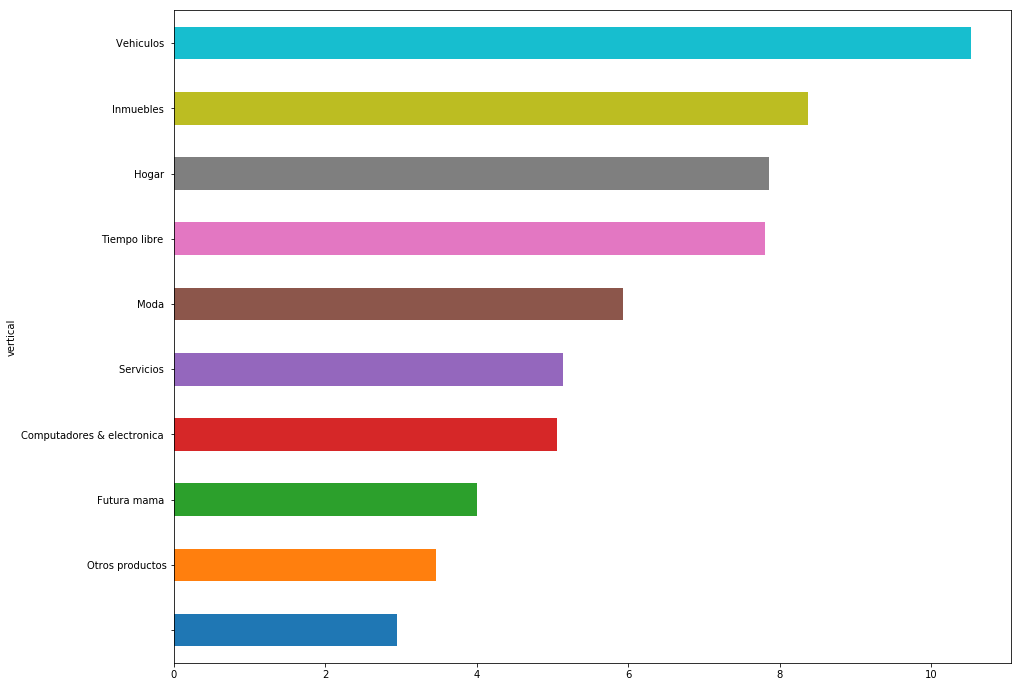

In [140]:
views_per_lead.plot.barh(figsize = (15,12))